# Issues for GANs on MNIST

### Ununiform distribution in latent space for vanilla GANs

For shallow vanilla GAN with structure:
* Generator: input_100 => fc_128 -> relu => fc_784 -> sigmoid => output_784
* Discriminator: input_784 => fc_128 -> relu => fc_1 -> sigmoid => output_1

the distribution of different digits in the latent space will become more and more ununiform during traininig. After training for around 100 epochs, digits 0, 1, 3, 5 and 8 seem to dominate the latent space, while other digits like 4 and 6 are rarely observed in the output of generator with latent z sampled from a stadard Gaussian distribution as input. Finally only one digit will occupy more than 95% of the latent space:

<img src="./images/helvetica00.png">

This can be remitted by increase the size of hidden layer in both G and D. A vanilla GAN with structure:
* Generator: input_100 => fc_256 -> lrelu => fc_784 -> sigmoid => output_784
* Discriminator: input_784 => fc_256 -> lrelu => fc_1 -> sigmoid => output_1

seems better during training, but the phenomenon is virtually delayed.

*28 July, 17*
* The phenomenon above may be called "the Helvetica scenario" in which $G$ collapses too many values of $z$ to the same value of $x$.
* A vanilla GAN with more than one hidden layer works for the first time. The structure is:
  * Generator: input_100 => fc_128 -> relu => fc_256 -> relu => fc_784 -> tanh -> rs => output_784
  * Discriminator: input_784 => rs => fc_256 -> lrelu => fc_128 -> lrelu => fc_1 -> sigmoid => output_1
  
Smooth factor must be set to less than 1.0 in the model above, otherwise discriminator will become too confident thus gradient will vanish.
Sometimes this model will die at d_loss = 0.325 (smooth factor is 0.9).


*31 July, 17*
* **Without resize layer and tanh activation, vanilla GANs with more than 1 hidden layer will die more easily during training.**
* Successfully built vanilla GAN with 3 hidden layers:
  * Generator: input_100 => fc_64 -> relu => fc_128 -> relu => fc_128 -> relu => fc_784 -> tanh -> rs => output_784
  * Discriminator: input_784 => rs => fc_128 -> lrelu => fc_128 -> lrelu => fc_64 -> lrelu => fc_1 -> sigmoid => output_1

Using cross_entropy_with_logits with one side label smoothing (factor $\alpha$), 
$$loss_{D} = -(1 - \alpha)\log(D(x_{data})) - \alpha\log(1 - D(x_{data})) - \log(1 - D(x_{sample}))$$ 
and 
$$loss_{G} = -\log(D(x_{sample}))$$
When G is completely defeated, $D_{data} = 1 - \alpha$ and $D_{sample} = 0$. Thus $loss_{D} = -(1-\alpha)\log(1-\alpha) - \alpha\log(\alpha)$ which equals to approximately $0.1412$ when $\alpha = 0.1$.

When converging,
$$D^*(x) = \frac{(1-\alpha)p_{data}(x)}{p_{data}(x) + p_{model}(x)} = \frac{1 - \alpha}{2}$$
where $p_{data} = p_{sample}$. At this time 
$$loss_D = -\log[(\frac{1-\alpha}{2})^{1-\alpha}(\frac{1+\alpha}{2})^{1+\alpha}]$$
which is approximately $0.5977$ when $\alpha$ is $0.1$


*7 Aug, 17*

A DCGAN with structure:
* Generator: input_100 => fc_6272 -> reshape_7x7x128 -> bn -> relu => deconv_14x14x128 -> bn -> relu => deconv_28x28x1 -> sigmoid => output_28x28x1
* Discriminator: input_28x28x1 => conv_14x14x128 -> lrelu => conv_7x7x128 -> bn -> lrelu -> reshape_6272 => fc_1 -> sigmoid => output_1

suffers from 'content vanishing' prombles:

<img src="./images/vanishing00.png">

This may be avoided by removing batchnorm layers:
* Generator: input_100 => fc_6272 -> reshape_7x7x128 -> relu => deconv_14x14x128 -> relu => deconv_28x28x1 -> sigmoid => output_28x28x1
* Discriminator: input_28x28x1 => conv_14x14x128 -> lrelu => conv_7x7x128 -> lrelu -> reshape_6272 => fc_1 -> sigmoid => output_1

*8 Aug, 17*

A DCGAN with struture:

* Generator: input_100 => fc_6272 -> relu -> reshape_7x7x128 => deconv_14x14x64 -> relu => deconv_28x28x1 -> tanh -> rs => output_28x28x1
* Discriminator: input_28x28x1 => rs => conv_14x14x64 -> lrelu => conv_7x7x128 -> lrelu -> reshape_6272 => fc_1 -> sigmoid => output_1

seems work well but has 'Helvetica' issue. **If rescale layers are removed, collapsing issue occurs much more slowly.**

In [1]:
# Do some setups
from __future__ import print_function

import random
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path += ['..\\..\\']

import models
from tframe import console
from tframe.utils import imtool

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print('>> Done ...')

In [2]:
# Get model 
model = models.dcgan('dcgan_c00')

>> Model built successfully:
... Generator: input_100 => concat_110 -> fc_6272 -> reshape_7x7x128 -> relu => deconv_14x14x128 -> relu => deconv_28x28x1 -> sigmoid => output_28x28x1
... Discriminator: input_28x28x1 => concat_28x28x11 -> conv_14x14x128 -> lrelu => conv_7x7x128 -> lrelu -> reshape_6272 => fc_1 -> sigmoid => output_1
>> Launching session ...
>> Session launched
>> Access to directory './records\checkpoints\dcgan_c00' ...
INFO:tensorflow:Restoring parameters from ./records\checkpoints\dcgan_c00\default.model-9844
>> Loaded default.model-9844


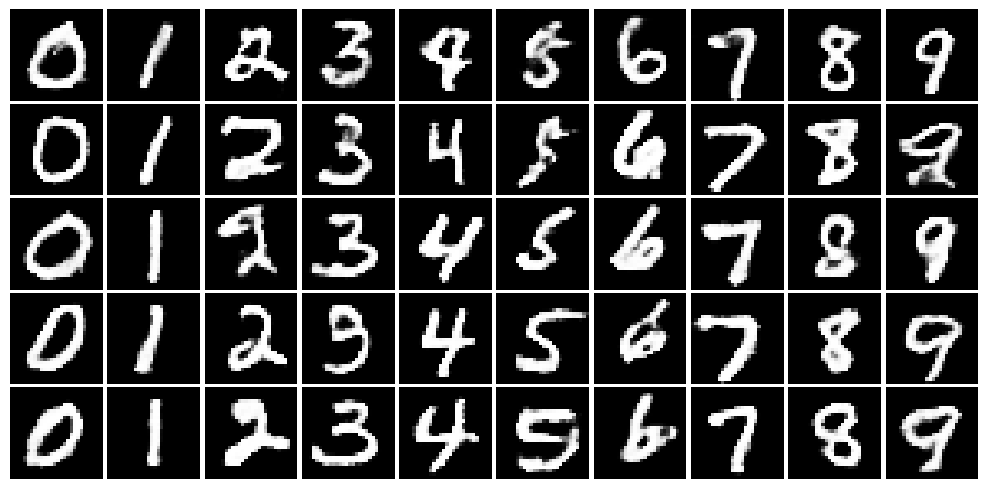

In [6]:
sample_num=10
rows = 5
samples = model.generate(labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 5)
fig = imtool.gan_grid_plot(samples, show=True, h=rows)